# **CSP571 - Project - GEONGU PARK**

## 1. Data Preparation


### 1.1 Import Required Libraries


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import seaborn as sb
from google.colab import files
import io
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score ,confusion_matrix
!pip install -q mglearn
import mglearn
from sklearn.decomposition import PCA
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.naive_bayes import GaussianNB

     |████████████████████████████████| 542kB 11.9MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1.2 Read pima diabetes dataset

In [2]:
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['diabetes.csv']))

Saving diabetes.csv to diabetes.csv


In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 1.3 Data Pre-processing


In [4]:
#Dropping Features based on VIF
model = ols('Outcome ~ Pregnancies + Glucose + BloodPressure + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age', data)
res = model.fit()
res.summary()

#Based on the result below, 
#Statistically Significant: Pregnancies, Glucose, BloodPressure, BMI, DiabetesPedigreeFunction
#Not Significant: SkinThickness, Insulin, Age

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     41.29
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           7.36e-55
Time:                        07:20:07   Log-Likelihood:                -381.91
No. Observations:                 768   AIC:                             781.8
Df Residuals:                     759   BIC:                             823.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.8539      0.085     -9.989      0.000      -1.022      -0.686
Pregnancies                  0.0206      0.005      4.014      0.000       0.011       0.031
Glucose                      0.0059      0.001     11.493      0.000       0.005       0.007
BloodPressure               -0.0023      0.001     -2.873      0.004      -0.004      -0.001
SkinThickness                0.0002      0.001      0.139      0.890      -0.002       0.002
Insulin                     -0.0002      0.000     -1.205      0.229      -0.000       0.000
BMI                          0.0132      0.002      6.344      0.000       0.009       0.017
DiabetesPedigreeFunction     0.1472      0.045      3.268      0.001       0.059       0.236
Age                          0.0026      0.002      1.693      0.091      -0.000       0.006
==============================================================================
Omnibus:                       41.539   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.183
Skew:                           0.395   Prob(JB):                     1.69e-07
Kurtosis:                       2.408   Cond. No.                     1.10e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [5]:
#Calculate VIF
pd.DataFrame({'Column': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept')

,Column,VIF
0,Pregnancies,1.430872
1,Glucose,1.298961
2,BloodPressure,1.181863
3,SkinThickness,1.507432
4,Insulin,1.427536
5,BMI,1.297450
6,DiabetesPedigreeFunction,1.067090
7,Age,1.588368


In [25]:
from patsy import dmatrices
features = "+".join(data.iloc[:, 0:-1])
vifY, vifX = dmatrices('Outcome ~' + features, data, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(vifX.values,i) for i in range(vifX.shape[1])]
vif["features"] = vifX.columns
vif.round(1)

,VIF Factor,features
0,35.0,Intercept
1,1.4,Pregnancies
2,1.3,Glucose
3,1.2,BloodPressure
4,1.5,SkinThickness
5,1.4,Insulin
6,1.3,BMI
7,1.1,DiabetesPedigreeFunction
8,1.6,Age


In [26]:
#Split Features and Output
columns = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']
X = data.iloc[:, 0:-1].values
Y = data.iloc[:,[-1]].values

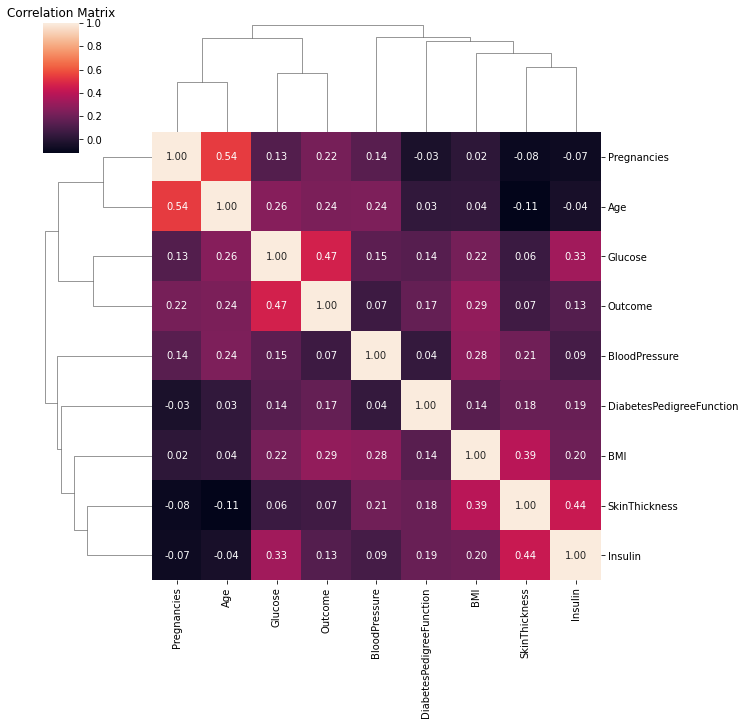

In [8]:
#Correlation Matrix
corr_matrix = data.corr()
sb.clustermap(corr_matrix, annot= True, fmt = '.2f')
plt.title('Correlation Matrix')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcfcb6bd30>,
      dtype=object)

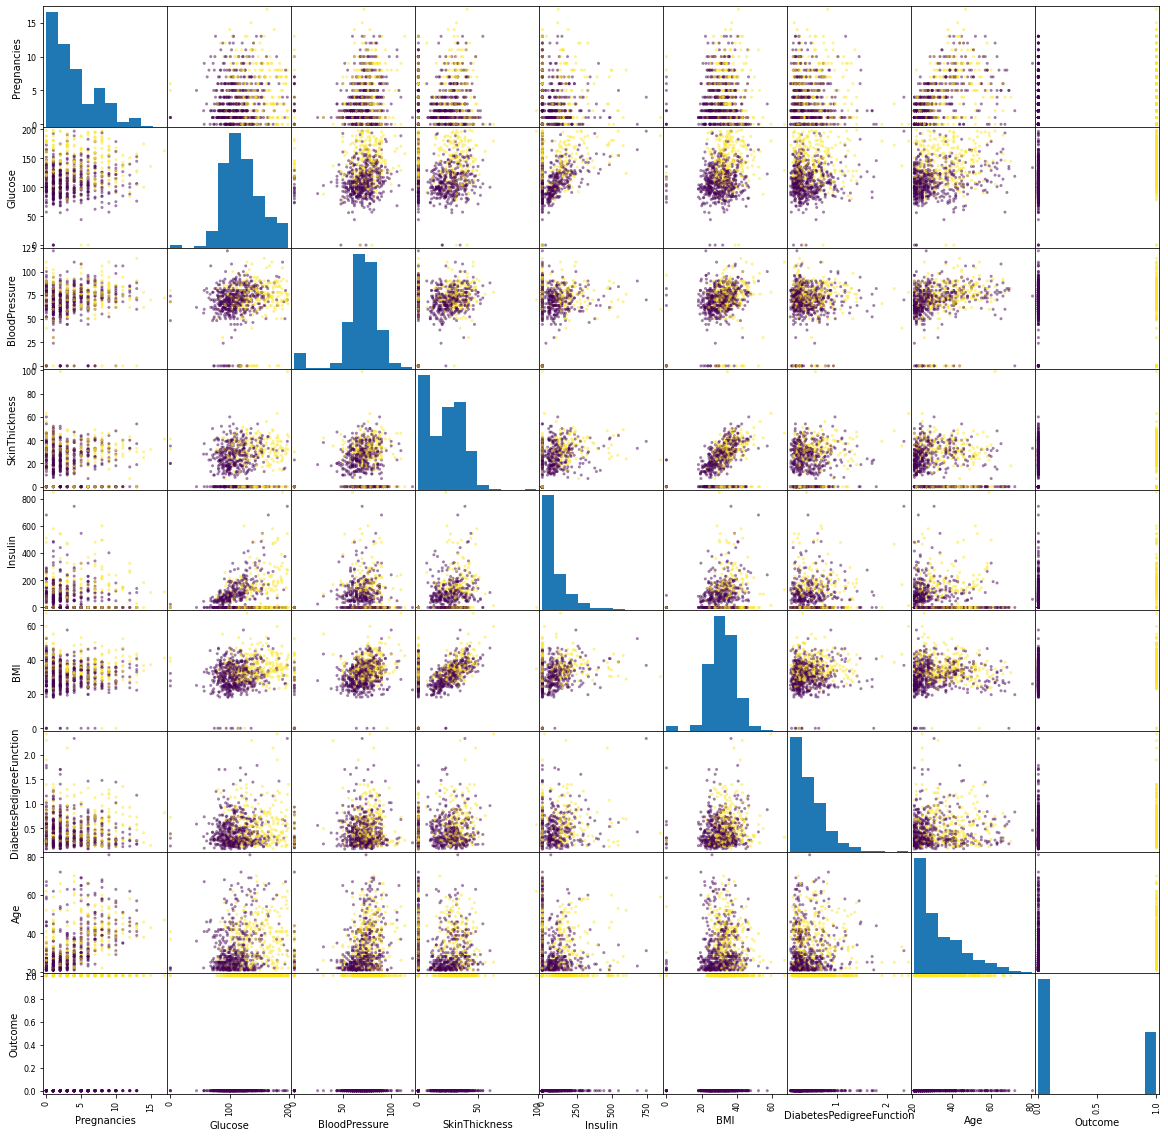

In [9]:
#Scatter Matrix of Features
pd.plotting.scatter_matrix(data,c=data['Outcome'], figsize=[20,20])

In [28]:
#Replace missing values
num_obs_arr = np.count_nonzero(X,axis=0)
dash = '-' * 60
print(dash)
print('{:<30s}{:<20}{:<10}'.format("Column","# Observations","Missing"))
print(dash)
#for i in range(len(columns)):
#    if i != 0 and i != len(columns)-1:
#        print('{:<30s}{:<20}{:<10}'.format(columns[i],num_obs_arr[i],768-num_obs_arr[i]))
#    else: print('{:<30s}{:<20}{:<10}'.format(columns[i],768,0))
#2.2 Replace 0 with mean of the each feature
imputer = SimpleImputer(missing_values=0,strategy='mean')
imputer = imputer.fit(X[:, 1:6])
X[:,1:6] = imputer.transform(X[:,1:6])

for i in range(len(columns)):
  print('{:<30s}{:<20}{:<10}'.format(columns[i],768,0))

#Normalize feature values
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

------------------------------------------------------------
Column                        # Observations      Missing   
------------------------------------------------------------
Pregnancies                   768                 0         
Glucose                       768                 0         
BloodPressure                 768                 0         
SkinThickness                 768                 0         
Insulin                       768                 0         
BMI                           768                 0         
DiabetesPedigreeFunction      768                 0         
Age                           768                 0         
Outcome                       768                 0         


In [11]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [12]:
#Model selection
processed_data = pd.DataFrame(X)
col_names = {0:'Pregnancies',1:'Glucose',2:'BloodPressure',3:'SkinThickness',
             4:'Insulin',5:'BMI',6:'DiabetesPedigreeFunction',7:'Age'}
processed_data = processed_data.rename(columns=col_names)
processed_data["Outcome"] = Y
processed_data
#processed_data.to_csv('processed_data.csv',header=True)
#files.download('processed_data.csv')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.170130,0.314928,0.234415,0.483333,1
1,0.058824,0.264516,0.428571,0.239130,0.170130,0.171779,0.116567,0.166667,0
2,0.470588,0.896774,0.408163,0.240798,0.170130,0.104294,0.253629,0.183333,1
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,1
...,...,...,...,...,...,...,...,...,...
763,0.588235,0.367742,0.530612,0.445652,0.199519,0.300613,0.039710,0.700000,0
764,0.117647,0.503226,0.469388,0.217391,0.170130,0.380368,0.111870,0.100000,0
765,0.294118,0.496774,0.489796,0.173913,0.117788,0.163599,0.071307,0.150000,0
766,0.058824,0.529032,0.367347,0.240798,0.170130,0.243354,0.115713,0.433333,1


In [13]:
#VIF calculation for multicollinearity check
features2 = "+".join(processed_data.iloc[:, 0:-1])
vifY2, vifX2 = dmatrices('Outcome ~' + features2, processed_data, return_type='dataframe')
vif2 = pd.DataFrame()
vif2["VIF Factor"] = [variance_inflation_factor(vifX2.values,i) for i in range(vifX2.shape[1])]
vif2["features"] = vifX2.columns
vif2

,VIF Factor,features
0,24.402204,Intercept
1,1.429998,Pregnancies
2,1.353074,Glucose
3,1.239114,BloodPressure
4,1.451069,SkinThickness
5,1.231335,Insulin
6,1.567784,BMI
7,1.045751,DiabetesPedigreeFunction
8,1.618502,Age


In [14]:
#Detected outliers from R
outlier_points = [350]
#influence_points = [229]
#leverage_points = [5,9,14,46,50,59,194,229,248,333,358,371,372,446,454,538,580,585,685,707]
#points = outlier_points + influence_points + leverage_points
del_ol_data = processed_data.drop(outlier_points)
X = del_ol_data.iloc[:, 0:-1].values
Y = del_ol_data.iloc[:,[-1]].values
#Train/Test Split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state = 1004)

##Logistic Regression - 0.7654 -> (leverage out) 0.7740 -> (outlier out)0.7732

In [15]:
#Logistic Regression
tf.random.set_seed(1234)
tf.model = tf.keras.Sequential()
tf.model.add(tf.keras.layers.Dense(units=1,input_dim=x_train.shape[1],activation='sigmoid'))
tf.model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.1), metrics=['accuracy'])
tf.model.summary()
fitted = tf.model.fit(x_train,y_train,epochs=100)
print("Accuracy: {0}".format(fitted.history['accuracy'][-1]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
20/20 [==============================] - 0s 801us/step - loss: 0.6765 - accuracy: 0.6313
Epoch 2/100
20/20 [==============================] - 0s 822us/step - loss: 0.6560 - accuracy: 0.6607
Epoch 3/100
20/20 [==============================] - 0s 869us/step - loss: 0.6490 - accuracy: 0.6607
Epoch 4/100
20/20 [==============================] - 0s 1ms/step - loss: 0.6434 - accuracy: 0.6607
Epoch 5/100
20/20 [==============================] - 0s 826us/step - loss: 0.6387 - accuracy: 0.6607
Epoch 6/100
20/20 [==============================] - 0s 808us/step - loss: 0.6339 - accuracy: 0.6607
Epoch 7/100
20/20 [==============================] -

5/5 [==============================] - 0s 1ms/step - loss: 0.5102 - accuracy: 0.7597


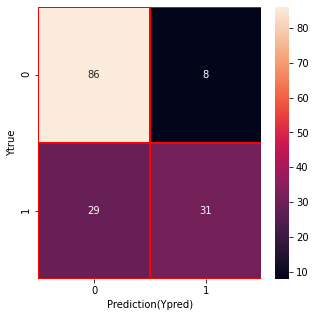

In [16]:
y_predict = tf.model.predict(x_test)
evaluate = tf.model.evaluate(x_test,y_test)

predictions = []
for num in y_predict:
  n = num[0]
  if n < 0.5: predictions.append(0)
  else: predictions.append(1)
CM = confusion_matrix(y_test,predictions)
f, ax = plt.subplots(figsize=(5,5))
sb.heatmap(CM,annot = True, linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Prediction(Ypred)")
plt.ylabel("Ytrue")
plt.show()

##KNN - 0.7857 -> 0.7284 -> 0.7402

# of Tests: 154, # of errors: 36
0.7662337662337663
[0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0
 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0
 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 0 0
 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1
 1 0 0 0 0 0]


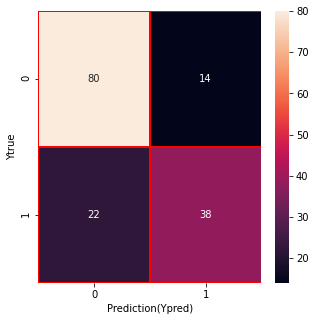

In [17]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, np.ravel(y_train,order='C'))
predictions = knn.predict(x_test)
accuracy = accuracy_score(y_test, predictions)
print("# of Tests: %d, # of errors: %d" %(len(y_test), (np.ravel(y_test, order='C') != predictions).sum()))
print(accuracy)

print(predictions)
CM = confusion_matrix(y_test,predictions)
f, ax = plt.subplots(figsize=(5,5))
sb.heatmap(CM,annot = True, linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Prediction(Ypred)")
plt.ylabel("Ytrue")
plt.show()


In [18]:
from sklearn.model_selection import cross_val_score
NB = GaussianNB()
accuracies = cross_val_score(estimator=NB, X= x_train, y=np.ravel(y_train,order="C"), cv=5)
print("Accuracy:", np.mean(accuracies))

Accuracy: 0.7520458483273357


Accuracy of NB:  0.7207792207792207


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


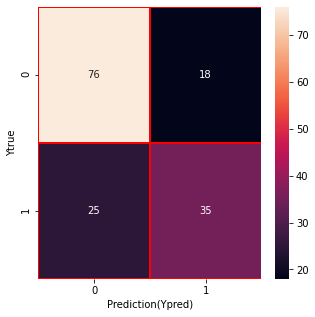

In [19]:
NB.fit(x_train,y_train)
print("Accuracy of NB: ", NB.score(x_test,y_test))
y_pred = NB.predict(x_test)
y_cm = y_test
CM = confusion_matrix(y_cm,y_pred)

f, ax = plt.subplots(figsize=(5,5))
sb.heatmap(CM,annot = True, linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Prediction(Ypred)")
plt.ylabel("Ytrue")
plt.show()

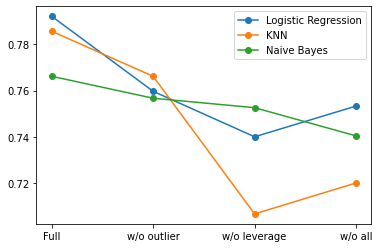

In [20]:
LR = [0.7922,0.7597,0.7400,0.7533]
KNN = [0.7857,0.7662, 0.7066, 0.72]
NB = [0.7662, 0.7567, 0.7526, 0.7404]
X = ["Full","w/o outlier","w/o leverage", "w/o all"]
plt.plot(X, LR, label="Logistic Regression", marker='o')
plt.plot(X, KNN, label = "KNN",marker='o')
plt.plot(X, NB, label = "Naive Bayes",marker='o')
plt.legend(loc='best')

No handles with labels found to put in legend.


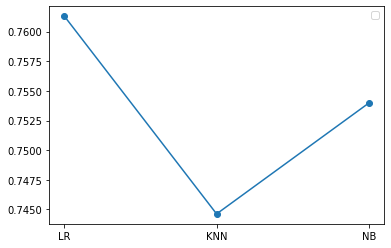

In [21]:
LR = [0.7922,0.7597,0.7400,0.7533]
KNN = [0.7857,0.7662, 0.7066, 0.72]
NB = [0.7662, 0.7567, 0.7526, 0.7404]

LR_mean = np.mean(LR)
KNN_mean = np.mean(KNN)
NB_mean = np.mean(NB)
means = [LR_mean,KNN_mean,NB_mean]
X = ["LR","KNN","NB"]
plt.plot(X, means, marker='o')
plt.legend(loc='best')